Setup

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard

# Create a TensorBoard callback
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

Read and transform the data

In [60]:
# load dataset
CCData = pd.read_csv("Credit_card.csv")
CCData2 = pd.read_csv("Credit_card_label.csv")
X = CCData[["Ind_ID","GENDER","Car_Owner","Propert_Owner","CHILDREN","Annual_income","Type_Income","EDUCATION",
        "Marital_status","Housing_type","Birthday_count","Employed_days","Mobile_phone","Work_Phone","Phone",
        "EMAIL_ID","Type_Occupation","Family_Members"]]
Y = CCData2[["label"]]

#Find and replace all 'NaN data
#Columns with string data get "N/A"
#Columns with numbered data get 0
listNan = X.loc[:, X.isna().any()]
for title in list(listNan):
  if X[title].dtype == 'object':
    X[title] = X[title].fillna('N/A')
  else:
    X[title] = X[title].fillna(0)

#Encode the catagorical data
le = LabelEncoder()
string_columns = X.select_dtypes(include=['object']).columns
for title in list(string_columns):
  X[title] = le.fit_transform(X[title].values)

# Standardizing the features and perform pca
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=3)
X = pca.fit_transform(X)


Graph for a 2 Componant PCA Data

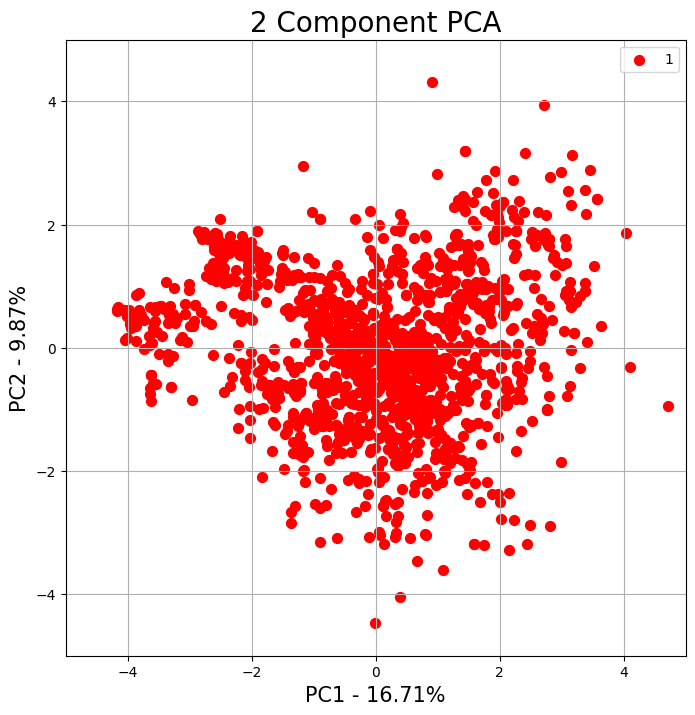

In [41]:
plot_df = pd.DataFrame(data = X, columns = ['PC1', 'PC2'])
plot_df = pd.concat([plot_df, Y], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

classes = [1,0]
colors = ['g', 'r']

for target, color in zip(classes, colors):
  #if target == 0:
    indicesToKeep = plot_df['label'] == target
    ax.scatter(plot_df.loc[indicesToKeep, 'PC1'], plot_df.loc[indicesToKeep, 'PC2'], c = color, s = 50)

ax.legend(classes)
ax.grid()
plt.xlabel('PC1 - {0}%'.format(round(pca.explained_variance_ratio_[0]*100, 2)))
plt.ylabel('PC2 - {0}%'.format(round(pca.explained_variance_ratio_[1]*100, 2)))
plt.show()

Graph For a 3 Componant PCA

In [54]:
df_3d = pd.DataFrame(X, columns=['PC1', 'PC2', 'PC3'])
df_3d['Label'] = Y
fig = px.scatter_3d(df_3d, x='PC1', y='PC2', z='PC3', color='Label')
fig.update_layout(scene=dict(
                    #xaxis=dict(range=[df_3d['PC1'].min(), df_3d['PC1'].max()]),
                    #yaxis=dict(range=[df_3d['PC2'].min(), df_3d['PC2'].max()]),
                    #zaxis=dict(range=[df_3d['PC3'].min(), df_3d['PC3'].max()]),
                    xaxis=dict(range=[-6, 6]),
                    yaxis=dict(range=[-6, 6]),
                    zaxis=dict(range=[-6, 6]),
                    aspectmode='cube',
                    xaxis_title='PC1 - {0}%'.format(round(pca.explained_variance_ratio_[0]*100, 2)),
                    yaxis_title='PC2 - {0}%'.format(round(pca.explained_variance_ratio_[1]*100, 2)),
                    zaxis_title='PC3 - {0}%'.format(round(pca.explained_variance_ratio_[2]*100, 2))
))

fig.show()

In [50]:
# Split the dataset into training and test sets
X, X_test, Y, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

#Turn Y into a matrix
Y = np.ravel(Y)
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Create and train the model repetitively and find the average accuracy for testing different variations of the nueral network.

In [8]:
avg_accuracy = 0
for i in range(10):
  #Create the model
  model = Sequential()
  model.add(Dense(16, input_dim=X.shape[1], activation='sigmoid'))
  model.add(Dense(16, activation='sigmoid'))
  model.add(Dense(4, activation='sigmoid'))
  model.add(Dense(4, activation='sigmoid'))
  #model.add(Dense(2, activation='sigmoid'))  # Output layer for 'sparse_categorical_crossentropy'
  model.add(Dense(1, activation='sigmoid'))  # Output layer for all of the others
  model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['Accuracy'])
  #Training the model
  history = model.fit(X, Y, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[tensorboard])
  avg_accuracy = avg_accuracy + model.evaluate(X_test,y_test)[1]
avg_accuracy = avg_accuracy/10
print(avg_accuracy)

Epoch 1/10
39/39 [==============================] - 4s 26ms/step - loss: 0.2697 - Accuracy: 0.1527 - val_loss: 0.2472 - val_Accuracy: 0.9032
Epoch 2/10
39/39 [==============================] - 1s 26ms/step - loss: 0.2292 - Accuracy: 0.8829 - val_loss: 0.2089 - val_Accuracy: 0.9032
Epoch 3/10
39/39 [==============================] - 0s 10ms/step - loss: 0.1971 - Accuracy: 0.8829 - val_loss: 0.1797 - val_Accuracy: 0.9032
Epoch 4/10
39/39 [==============================] - 0s 10ms/step - loss: 0.1735 - Accuracy: 0.8829 - val_loss: 0.1582 - val_Accuracy: 0.9032
Epoch 5/10
39/39 [==============================] - 0s 9ms/step - loss: 0.1563 - Accuracy: 0.8829 - val_loss: 0.1422 - val_Accuracy: 0.9032
Epoch 6/10
39/39 [==============================] - 0s 10ms/step - loss: 0.1436 - Accuracy: 0.8829 - val_loss: 0.1304 - val_Accuracy: 0.9032
Epoch 7/10
39/39 [==============================] - 0s 10ms/step - loss: 0.1342 - Accuracy: 0.8829 - val_loss: 0.1211 - val_Accuracy: 0.9032
Epoch 8/10
39/

**1: 2 componants with learning rate = 0.01**
1.   loss='sparse_categorical_crossentropy', Accuracy = 0.903
2.   loss='mse', Accuracy = 0.903
3.   loss='msle', Accuracy = 0.903
4.   loss = 'poisson', Accuracy = 0.903
5.   loss='binary_crossentropy', Accuracy = 0.903

**2: 3 componants with learning rate = 0.01**
1.   loss='mse', Accuracy = 0.8829






In [51]:
#Create the model
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(4, activation='sigmoid'))
model.add(Dense(4, activation='sigmoid'))
#model.add(Dense(2, activation='sigmoid'))  # Output layer for 'sparse_categorical_crossentropy'
model.add(Dense(1, activation='sigmoid'))  # Output layer for all of the others
model.compile(loss='msle',
              optimizer=Adam(learning_rate=0.001),
              metrics=['BinaryAccuracy'])
#Training the model
history = model.fit(X, Y, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[tensorboard])

Epoch 1/20
39/39 [==============================] - 2s 11ms/step - loss: 0.0785 - binary_accuracy: 0.8829 - val_loss: 0.0685 - val_binary_accuracy: 0.9032
Epoch 2/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0673 - binary_accuracy: 0.8829 - val_loss: 0.0591 - val_binary_accuracy: 0.9032
Epoch 3/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0607 - binary_accuracy: 0.8829 - val_loss: 0.0534 - val_binary_accuracy: 0.9032
Epoch 4/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0568 - binary_accuracy: 0.8829 - val_loss: 0.0500 - val_binary_accuracy: 0.9032
Epoch 5/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0544 - binary_accuracy: 0.8829 - val_loss: 0.0478 - val_binary_accuracy: 0.9032
Epoch 6/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0529 - binary_accuracy: 0.8829 - val_loss: 0.0463 - val_binary_accuracy: 0.9032
Epoch 7/20
39/39 [==============================] - 0s 6ms/step - loss: 0.0